In [52]:
import torch 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import EWOthello.utils.plot_helpers as plt_util

from EWOthello.mingpt.model import GPTConfig,  GPTforProbeIA, GPTforProbeIA_ModV1
from EWOthello.data.othello import * # permit_reverse lives here and takes board integer to board's tile string
from EWOthello.mingpt.dataset import CharDataset
from EWOthello.mingpt.probe_model import BatteryProbeClassificationTwoLayer, BatteryProbeClassification

from EWOthello.mingpt.utils import  intervene

In [53]:
if torch.cuda.is_available():
    device = torch.cuda.current_device()


In [3]:
real_data_path = "../EWOthello/data/othello_championship/"
# View the processed, real game sequences
# pgn files contain the real game data records
# Games after pgn loader is a datastructure with attributed move
fn = os.listdir(real_data_path)
print("file_name: ", fn[0], "\n")
with open(real_data_path + fn[0], "r") as fhandle:
    pgn_text = fhandle.read()
    pgn_games_obj = pgn.loads(pgn_text)

game1 = pgn_games_obj[0]
game1_moves = game1.moves
print("first game: ", game1, "\n")
print("game moves: ", game1_moves)

# KLi Othello converts moves to board number 
rows = list("ABCDEFGH")
columns = [str(_) for _ in range(1, 9)]
sequence = []
for move in game1_moves:
    sequence.append(rows.index(move[0]) * 8 + columns.index(move[1]))
print("game sequence processed: ", sequence)

file_name:  WTHOR-1990.pgn 

first game:  <PGNGame "Veleskevich Vladimi" vs "Melnikov Aleksandr"> 

game moves:  ['F5', 'F6', 'E6', 'F4', 'G5', 'E7', 'F7', 'H6', 'E3', 'D6', 'H5', 'G6', 'G4', 'D3', 'D8', 'H3', 'H4', 'G3', 'F3', 'F8', 'C2', 'E2', 'D2', 'C4', 'C3', 'G8', 'F1', 'D1', 'D7', 'B4', 'C1', 'E1', 'F2', 'B3', 'C6', 'C5', 'C7', 'B6', 'B7', 'G2', 'E8', 'A8', 'H8', 'H7', 'G7', 'B8', 'B2', 'C8', 'G1', 'H1', 'H2', 'B1', 'A1', 'A2', 'A3', 'A4', 'A5', 'B5', 'A7', 'A6']
game sequence processed:  [44, 45, 37, 43, 52, 38, 46, 61, 34, 29, 60, 53, 51, 26, 31, 58, 59, 50, 42, 47, 17, 33, 25, 19, 18, 55, 40, 24, 30, 11, 16, 32, 41, 10, 21, 20, 22, 13, 14, 49, 39, 7, 63, 62, 54, 15, 9, 23, 48, 56, 57, 8, 0, 1, 2, 3, 4, 12, 6, 5]


In [54]:
game_sequence = sequence[:20]

# put the game sequence as othello board class
ab = OthelloBoardState()
ab.update(game_sequence, prt=False)
ab.__print__()

othello = get(ood_perc=0., data_root=None, wthor=False, ood_num=1)
train_dataset = CharDataset(othello)
partial_game = torch.tensor([train_dataset.stoi[s] for s in game_sequence], dtype=torch.long).to(device)

padding = torch.zeros(2).cuda() # Add in center two tiles with zero padding because output skips over them


--------------------
['f5', 'f6', 'e6', 'f4', 'g5', 'e7', 'f7', 'h6', 'e3', 'd6', 'h5', 'g6', 'g4', 'd3', 'd8', 'h3', 'h4', 'g3', 'f3', 'f8']
a                
b                
c                
d     O O O O   X
e     X O O O O  
f     X X X X X O
g     O X O O    
h     O X X O    
  1 2 3 4 5 6 7 8
--------------------


100%|██████████| 1/1 [00:00<00:00, 51.51it/s]

Dataset created has 1 sequences, 61 unique words.


In [55]:
probesLinear = {} # We need the pre-trained probes for the layer we want and all layers after it according to their theory
layer_s = 8
layer_e = 9
for layer in range(layer_s, layer_e):
    p = BatteryProbeClassification(torch.cuda.current_device(), probe_class=3, num_task=64)
    #load_res = p.load_state_dict(torch.load(f"../EWOthello/ckpts/LinearProbe_8Layer_v2_Synthetic_GPT8x8/checkpoint.ckpt"))
    load_res = p.load_state_dict(torch.load(f"../EWOthello/ckpts/battery_othello/state/layer8/checkpoint.ckpt"))
    p.eval()
    probesLinear[layer] = p

In [56]:
probesNonlinear = {} # We need the pre-trained probes for the layer we want and all layers after it according to their theory
layer_s = 8
layer_e = 9
for layer in range(layer_s, layer_e):
    p = BatteryProbeClassificationTwoLayer(torch.cuda.current_device(), probe_class=3, num_task=64, mid_dim=128)
    load_res = p.load_state_dict(torch.load(f"../EWOthello/ckpts/battery_othello/state_tl128/layer{layer}/checkpoint.ckpt"))
    p.eval()
    probesNonlinear[layer] = p


Load a pre-trained model.

In [57]:
othello = get(ood_perc=0., data_root=None, wthor=False, ood_num=1)
train_dataset = CharDataset(othello)

mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)
model = GPTforProbeIA_ModV1(mconf)
load_res = model.load_state_dict(torch.load("../EWOthello/ckpts/gpt_synthetic.ckpt"))

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model = model.to(device)
_ = model.eval()

100%|██████████| 1/1 [00:00<00:00, 52.00it/s]


Dataset created has 1 sequences, 61 unique words.


1
d6
-1.0
{'intervention_position': 'd6', 'intervention_from': 0.0, 'intervention_to': 2.0}
d6 Failed intervention! See the below two borads:
labels_post_intv_reality
--------------------
[]
a                
b                
c                
d     O O O X   X
e     O O O O O  
f     X X X X X X
g     X X X O    
h     O X X O    
  1 2 3 4 5 6 7 8
--------------------
labels_post_intv_wished
--------------------
[]
a                
b                
c                
d     O O O X   X
e     O O O O O  
f     X X X X X X
g     O X X O    
h     O X X O    
  1 2 3 4 5 6 7 8
--------------------


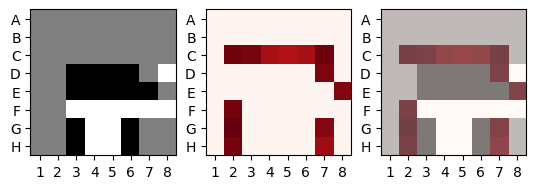

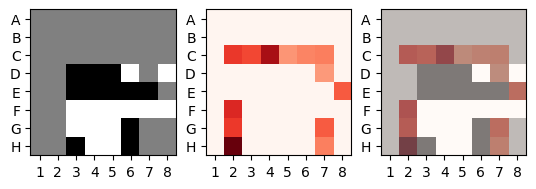

In [58]:

# CHOOSE TO USE LINEAR OR NONLINEAR PROBE SET
probes = probesNonlinear #probesLinear
htd = {"lr": 1e-3, "steps": 1000, "reg_strg": 0.2}
wtd = {}
# initial probing is starting at layer_s defined above
print(ab.next_hand_color)

#for square in [permit_reverse(_) for _ in range(64)]: # Iterate over tile string name
for square in [permit_reverse(_) for _ in [29]]: # Iterate over tile string name
    print(square)
    # Define intervention action by flipping that tile if there is a piece there
    wtd["intervention_position"] = square
    move = permit(wtd["intervention_position"]) # convert tile name to move integer
    r, c = move // 8, move % 8

    print(ab.state[r,c])
    wtd["intervention_from"] = ab.state[r, c] + 1
    wtd["intervention_to"] = 2 - wtd["intervention_from"]
    print(wtd)
    
    # Get the layer activation and use probe to get the board state
    whole_mid_act = model.forward_1st_stage(layer_s, partial_game[None, :]) 
    this_probe = probes[layer_s]
    pre_intv_Probelogits = this_probe(whole_mid_act[0:1, -1])[0].squeeze(0)  # [64, 3]
    pre_intv_ProbeBoard = pre_intv_Probelogits.detach().argmax(dim=-1)

    pre_intv_pred, _ = model.predict(whole_mid_act)
    pre_intv_pred = pre_intv_pred[0, -1, 1:]  
    pre_intv_pred = torch.cat([pre_intv_pred[:27], padding, pre_intv_pred[27:33], padding, pre_intv_pred[33:]], dim=0)
    #pre_intv_pred = pre_intv_pred.detach().cpu().numpy().reshape(8, 8)
    pre_intv_pred = torch.softmax(pre_intv_pred, dim=0).detach().cpu().numpy().reshape(8, 8)

    show_board = np.reshape(pre_intv_ProbeBoard.cpu(), [8, 8])
    fig = plt.figure(frameon=True)
    ax = plt_util.addAxis(fig, 1, 3)
    im1 = ax[0].imshow(show_board, cmap = plt.cm.gray)
    im2 = ax[1].imshow(pre_intv_pred, cmap=plt.cm.Reds, alpha=1.0)
    ax[2].imshow(show_board, cmap = plt.cm.gray)
    ax[2].imshow(pre_intv_pred, cmap=plt.cm.Reds, alpha=0.5)

    for thisaxis in ax:
        thisaxis.set_yticks(ticks=list(range(0,8)))
        thisaxis.set_yticklabels("ABCDEFGH")
        thisaxis.set_xticks(ticks=list(range(0,8)))
        thisaxis.set_xticklabels(list(range(1,9)))

    # Intervene to get a new activation which provides the new board state
    mid_act = whole_mid_act[0, -1]  
    new_mid_act = intervene(this_probe, mid_act.clone(), pre_intv_ProbeBoard, wtd, htd, plot=True)
    post_intv_Probelogits = this_probe(new_mid_act[None, :])[0].squeeze(0)  # [64, 3]
    post_intv_ProbeBoard = post_intv_Probelogits.detach().argmax(dim=-1)
    
    post_intv_pred, _ = model.predict(new_mid_act)
    post_intv_pred = post_intv_pred[1:]  
    post_intv_pred = torch.cat([post_intv_pred[:27], padding, post_intv_pred[27:33], padding, post_intv_pred[33:]], dim=0)
    #pre_intv_pred = pre_intv_pred.detach().cpu().numpy().reshape(8, 8)
    post_intv_pred = torch.softmax(post_intv_pred, dim=0).detach().cpu().numpy().reshape(8, 8)

    
    show_board = np.reshape(post_intv_ProbeBoard.cpu(), [8, 8])

    fig = plt.figure(frameon=True)
    ax = plt_util.addAxis(fig, 1, 3)
    im1 = ax[0].imshow(show_board, cmap = plt.cm.gray)
    im2 = ax[1].imshow(post_intv_pred, cmap=plt.cm.Reds, alpha=1.0)
    ax[2].imshow(show_board, cmap = plt.cm.gray)
    ax[2].imshow(post_intv_pred, cmap=plt.cm.Reds, alpha=0.5)

    for thisaxis in ax:
        thisaxis.set_yticks(ticks=list(range(0,8)))
        thisaxis.set_yticklabels("ABCDEFGH")
        thisaxis.set_xticks(ticks=list(range(0,8)))
        thisaxis.set_xticklabels(list(range(1,9)))

    
    # board_post = np.reshape(labels_post_intv.cpu(), [8, 8])
    # im = ax[1].imshow(board_post)
    # divider = make_axes_locatable(ax[0])
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    # plt.colorbar(im, cax=cax)
   
    # # swap the mid activations then propagate updates to downstream layers
    # whole_mid_act[0, -1] = new_mid_act
    # for i, layer in enumerate(range(layer_s, layer_e - 1)):  # 4, 5, 6, 7, indices of the layers to be passed
    #     whole_mid_act = model.forward_2nd_stage(whole_mid_act, layer, layer+1)[0]  # [1, T, F=512]

    #     # intervene the output of the features freshly out
    #     mid_act = whole_mid_act[0, -1]
    #     this_probe = probes[layer+1]
    #     pre_intv_logits = this_probe(mid_act[None, :])[0].squeeze(0)  # [64, 3]
    #     labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
    #     new_mid_act = intervene(this_probe, mid_act.clone(), labels_pre_intv, wtd, htd, plot=True)
    #     whole_mid_act[0, -1] = new_mid_act

    # tb_resumed = whole_mid_act
    # post_intv_pred, _ = model.predict(tb_resumed)    
    # post_intv_pred = post_intv_pred[0, -1, 1:]
    # post_intv_pred = torch.cat([post_intv_pred[:27], padding, post_intv_pred[27:33], padding, post_intv_pred[33:]], dim=0)
    # if 0:
    #     gems[square] = torch.softmax(post_intv_pred, dim=0).detach().cpu().numpy().reshape(8, 8)
    # else:   
    #     gems[square] = post_intv_pred.detach().cpu().numpy().reshape(8, 8)

    # print(post_intv_pred.shape)
    # this = torch.softmax(post_intv_pred, dim=0).detach().cpu().numpy().reshape(8, 8)
    # #this = post_intv_pred.detach().cpu().numpy().reshape(8, 8)
    # ax[2].imshow(this)
    # plt.show()

    break

Now we may plot the intervention boards via latent-saliency maps. We look at the set of moves that were previously legal and see how a flip at each tile location changes that moves logits

In [9]:
print(gems.keys()) # We added the post intervention game boards to the gems dict, indexed by the tile location

dict_keys(['pre', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8'])


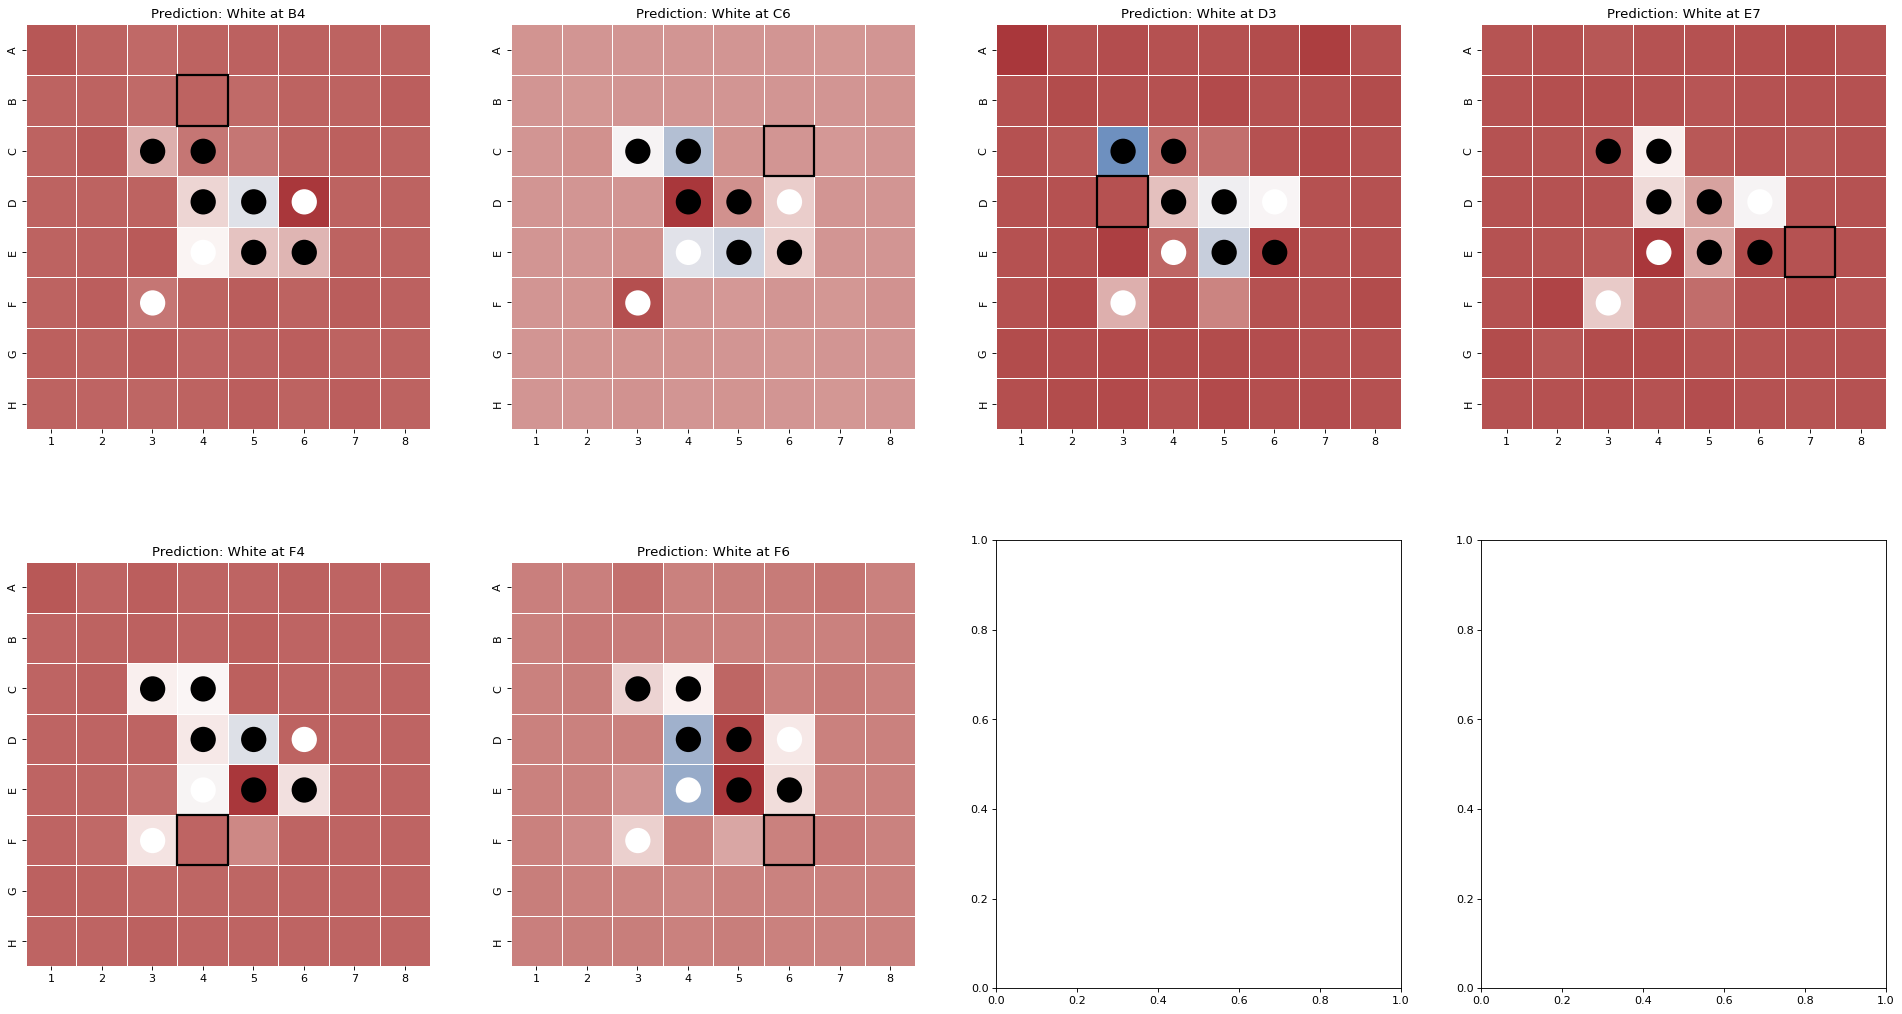

In [10]:
tbu = pre_intv_valids
total = len(tbu)
rows = int(np.ceil(total / 4))
fig, axs = plt.subplots(rows, 4, figsize=(30, rows * 8), dpi= 80, facecolor='w', edgecolor='k')
axs = axs.flat

for i, tobe_tcaved in enumerate(tbu):
    # Identify the tile location that we want to see get's affected if other board tiles are flipped
    pred = permit(tobe_tcaved)
    r_pred, c_pred = pred // 8, pred % 8

    # loop through the per-tile interventions and record the difference in predicted logit
    tbp = np.zeros((8, 8))
    pre = gems["pre"]
    for k, w in gems.items():
        if k == "pre":
            continue
        move = permit(k)  # 0-63
        r, c = move // 8, move % 8
        tbp[r, c] = - w[r_pred, c_pred] + pre[r_pred, c_pred]
        ab.plot_hm(axs[i], tbp.flatten(), permit(tobe_tcaved), logit=True)
